<a href="https://colab.research.google.com/github/cosshoon/Anomaly-Detection-/blob/main/Autoencoder_example_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoencoder 활용 MNIST 이미지셋 인코딩/디코딩으로 복원 예제

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train.shape


(60000, 28, 28, 1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


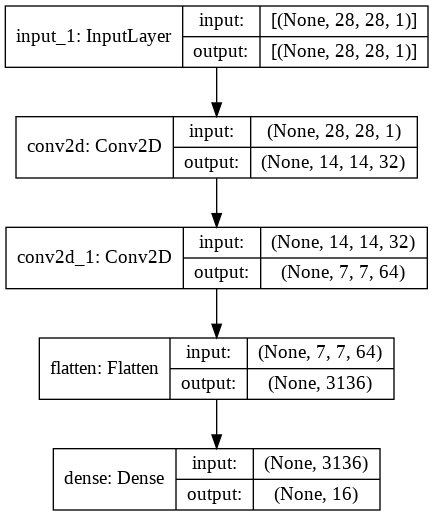

In [ ]:
inputs = Input(shape=(28,28,1))
x = Conv2D(32,3,activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(64,3,activation='relu', strides=2, padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent_z = Dense(16)(x)

encoder = Model(inputs,latent_z)
encoder.summary()
plot_model(encoder,
            to_file = 'encoder.png',
            show_shapes = True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

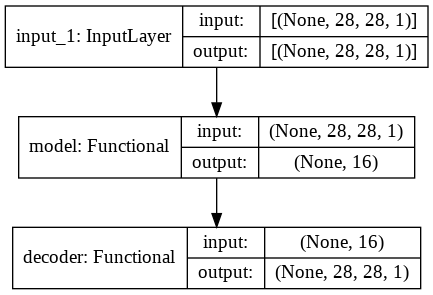

In [ ]:
latent_inputs = Input(shape=(16,))
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(64,3,activation = 'relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32,3,activation = 'relu', strides=2, padding='same')(x)
x_tilde = Conv2DTranspose(1,3,activation = 'sigmoid', padding='same')(x)

decoder = Model(latent_inputs, x_tilde, name='decoder')
decoder.summary()

plot_model(decoder, to_file='decoder.png', show_shapes=True)

autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs = 10, batch_size = 32)

Epoch 1/10
1875/1875 [==============================] - 22s 3ms/step - loss: 0.0420 - val_loss: 0.0105
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.00

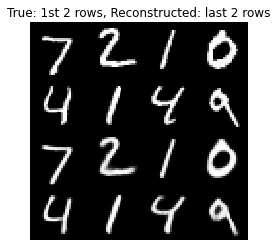

In [ ]:
x_decoded = autoencoder.predict(x_test)
imgs = np.concatenate([x_test[:8], x_decoded[:8]])

imgs = imgs.reshape((4,4,image_size,image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('True: 1st 2 rows, Reconstructed: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()
